In [1]:
import os
import cv2
import numpy as np
import pandas as pd

In [2]:
# Carpeta base donde estamos trabajando
base_folder = "."

In [3]:
# Obtener las subcarpetas (A, B, C, etc.)
categories = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

# Lista para almacenar datos
data = []
labels = []

In [4]:
# Dimensiones de las imágenes
height, width = 28, 28

In [5]:
# Leer imágenes de cada categoría
for category in categories:
    folder_path = os.path.join(base_folder, category)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):  # Procesar solo imágenes
            img_path = os.path.join(folder_path, file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
            if image is not None:
                image_flattened = image.flatten()  # Aplanar la imagen (784 valores)
                data.append(image_flattened)
                labels.append(category)

- *Aplanar imagenes:* Para poder aplicar PCA tenemos que aplanar las matrices. La estructura que necesitamos es una matriz cuadrada, donde cada imagen es un vector.
  - Pasamos de tener una imagen que representa una matriz de [28x28] a un vector que representa la información de esa matriz, pero ahora un vector de dimensión [1x784] (28 x 28 = 784).
  - De esta forma, aplanamos nuestras imágenes convirtiéndolas a vectores, y las juntamos para crear nuestra matriz de datos.

In [6]:
# Convertir a matrices numpy
data = np.array(data, dtype="float32")  # Matriz de datos (n_imágenes x 784)
labels = np.array(labels)  # Etiquetas correspondientes

# Imprimir dimensiones
print("Dimensiones de la matriz de datos:", data.shape)  # (n_imágenes, 784)
print("Dimensiones de las etiquetas:", labels.shape)

Dimensiones de la matriz de datos: (27454, 784)
Dimensiones de las etiquetas: (27454,)


- Como vemos, ahora nuestra matriz de datos es de dimensión [27455x784] que contiene 27455 registros (imágenes), los cuales vienen siendo los vectores de nuestras 27455 imágenes, y 784 columnas, que vienen siento los pixeles (variables) aplanados.  

- Nuestra matriz de datos X es muy grande ya que tenemos 784 variables. PCA nos ayudará extraer toda la informacion de esos datos y reducirla a algo mas chico.

## ***Train Test Split***
Realizamos un split de los datos antes de realizar la transformación del PCA
Esta división se realiza para aplicar PCA ÚNICAMENTE AL CONJUNTO DE ENTRENAMIENTO, para evitar Data Leakage
Durante el PCA se calculan las componentes principales en base a las características del Training set, si dieramos al PCA acceso a la información del test set, es decir a las características del test set, no haría sentido ya que podemos generar un sesgo.
Ya que en realidad, el test set, se supone que son datos que no tienes a la mano, entonces no tiene sentido darle al modelo los datos de antemano.

In [7]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train.shape

(21963, 784)

# ***ALGORITMO PCA***

## ***1. Vector de medias muestrales x_bar***

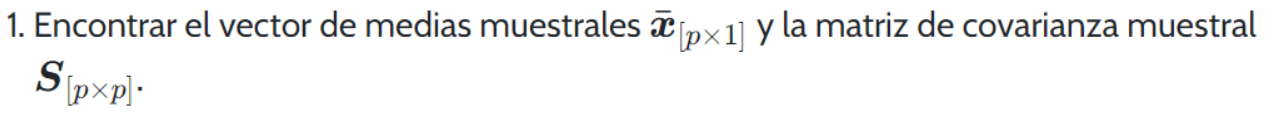

In [8]:
x_bar = X_train.mean(axis=0)
print("Vector de medias (x_bar):", x_bar)
print("Dimensiones de x_bar:", x_bar.shape)  # (784,)

Vector de medias (x_bar): [145.79283  148.4291   151.34131  153.90361  156.35533  158.52957
 160.7005   162.52957  164.05646  165.59615  166.76173  167.95752
 168.53886  169.33351  170.14174  170.52798  171.01685  170.97969
 170.78336  170.63406  170.12416  169.26431  168.22282  167.05923
 166.03833  163.89223  162.20157  161.63165  147.18117  149.89719
 152.8471   155.3893   157.88963  160.15544  162.25934  164.11273
 165.70865  166.97305  168.31581  169.28224  169.60475  170.41547
 170.84364  170.6566   170.72731  171.37473  171.38779  171.33392
 171.11702  170.49583  169.92783  168.7265   167.24979  165.31403
 163.71825  163.07463  149.2256   151.9714   154.85316  157.432
 160.00287  162.28421  164.2797   166.16533  167.51814  168.426
 170.03697  170.95001  170.5645   170.7718   169.99254  168.95624
 169.14825  169.39412  169.48936  170.03374  170.92747  170.97218
 170.79301  169.94733  168.82854  167.00319  165.57802  164.82831
 151.05031  153.84702  156.68811  159.39713  161.84933

## ***2. Matriz de covarianza muestral (*S*)***
- Encontramos la matriz de covarianza muestral ***S***.
- Para hacer PCA primero encontramos nuestra matriz de covarianza, la cual tenemos que estimar porque es desconocida.

In [9]:
# Matriz de covarianza muestral
Sigma = np.cov(X_train.T)  # Transponemos para que las columnas sean las variables
print("Dimensiones de la matriz de covarianza (Sigma):", Sigma.shape)  # (784, 784)

Dimensiones de la matriz de covarianza (Sigma): (784, 784)


## ***3. Eigenvalores y eigenvectores***

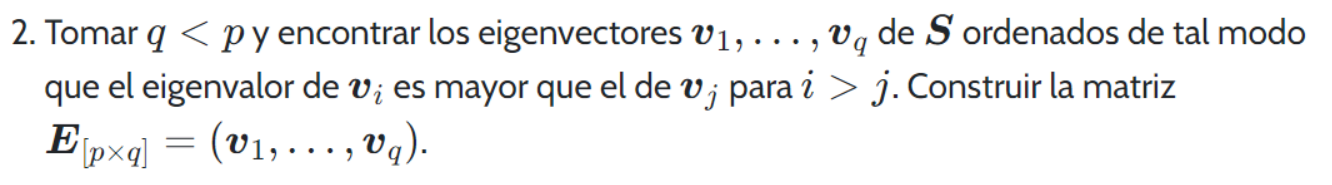

- Teniendo la matriz de covarianza muestral ***S***, aplicamos lo siguiente:
  - De ***S*** necesitamos calcular todas los componetes principales (Z1, Z2, ..., Zn),  y para cada una de los componentes, necesitamos encontrar sus vectores de loading correspondientes (**a1**, **a2**, ..., **a3**).
  - Los loadings son desconocidos, sin embargo, por resultados anteriores sabemos que son los eigenvectores de ***S***.
  - Sabemos que la primer componente principal debe explicar la mayor cantidad de varianza posible en los datos, la segunda componente explica la mayor cantidad de varianza restante y asi sucesivamente, de forma que va decreciendo la varianza de cada componente. Por resultados anteriores, sabemos que la varianza de los componentes corresponden a los eigenvalores de ***S***, ordenados de mayor a menor (lambda1 > lambda2 ... > lambdap).
  - De esta forma, asignamos los vectores de loadings de cada componente pricipal segun su eigenvalor asociado; i.e el eigenvalor más grande sería la varianza de la primer componente principal *Var(Z1) = lambda1*, y el eigenvector asociado a *lambda1*, sería el vector de loadings de la primer componente ***a1 = v1***.

In [10]:
# Eigenvalores y eigenvectores
Lambda, Q = np.linalg.eig(Sigma)
print("Eigenvalores (Lambda):", Lambda)
print("Dimensiones de Lambda:", Lambda.shape)  # (784,)
print("Matriz de eigenvectores (Q):", Q)
print("Dimensiones de Q:", Q.shape)  # (784, 784)


Eigenvalores (Lambda): [5.31518114e+05 1.63459141e+05 1.32039727e+05 8.69485505e+04
 5.61044349e+04 5.35554978e+04 4.62738932e+04 4.03736664e+04
 3.73963731e+04 2.96113123e+04 2.83562048e+04 2.49159082e+04
 2.14612804e+04 2.05851430e+04 1.73581846e+04 1.50153881e+04
 1.33480595e+04 1.28407715e+04 1.17130178e+04 1.07903424e+04
 9.86630931e+03 9.19979536e+03 8.33101843e+03 8.10264204e+03
 7.78501326e+03 7.27622623e+03 6.72753960e+03 6.31474156e+03
 6.11212298e+03 5.85914590e+03 5.73144219e+03 5.62831051e+03
 5.39082247e+03 5.17935294e+03 5.08089433e+03 4.74311453e+03
 4.71422051e+03 4.56431333e+03 4.41534694e+03 4.27468549e+03
 4.12788895e+03 4.03194692e+03 3.93073315e+03 3.84770827e+03
 3.64219204e+03 3.51510975e+03 3.44827881e+03 3.28895670e+03
 3.27023423e+03 3.18687044e+03 3.07392139e+03 2.99104463e+03
 2.93126301e+03 2.83764472e+03 2.80855950e+03 2.73554984e+03
 2.61996342e+03 2.58237358e+03 2.51818286e+03 2.45082450e+03
 2.41766163e+03 2.33898529e+03 2.28891875e+03 2.23517062e+03
 

### ***3.1 Ordenamos eigenvalores y eigenvectores***

In [11]:
idx = Lambda.argsort()[::-1]  # Índices para ordenar de mayor a menor
Lambda = Lambda[idx]
Q = Q[:, idx]
print("Eigenvalores ordenados:", Lambda)
print("Matriz de eigenvectores ordenada (Q):", Q)

Eigenvalores ordenados: [5.31518114e+05 1.63459141e+05 1.32039727e+05 8.69485505e+04
 5.61044349e+04 5.35554978e+04 4.62738932e+04 4.03736664e+04
 3.73963731e+04 2.96113123e+04 2.83562048e+04 2.49159082e+04
 2.14612804e+04 2.05851430e+04 1.73581846e+04 1.50153881e+04
 1.33480595e+04 1.28407715e+04 1.17130178e+04 1.07903424e+04
 9.86630931e+03 9.19979536e+03 8.33101843e+03 8.10264204e+03
 7.78501326e+03 7.27622623e+03 6.72753960e+03 6.31474156e+03
 6.11212298e+03 5.85914590e+03 5.73144219e+03 5.62831051e+03
 5.39082247e+03 5.17935294e+03 5.08089433e+03 4.74311453e+03
 4.71422051e+03 4.56431333e+03 4.41534694e+03 4.27468549e+03
 4.12788895e+03 4.03194692e+03 3.93073315e+03 3.84770827e+03
 3.64219204e+03 3.51510975e+03 3.44827881e+03 3.28895670e+03
 3.27023423e+03 3.18687044e+03 3.07392139e+03 2.99104463e+03
 2.93126301e+03 2.83764472e+03 2.80855950e+03 2.73554984e+03
 2.61996342e+03 2.58237358e+03 2.51818286e+03 2.45082450e+03
 2.41766163e+03 2.33898529e+03 2.28891875e+03 2.23517062e+03


## ***4. Seleccionar componentes principales***

**Cuantas componentes seleccionamos?**

- Una regla de dedo dice que seleccionemos componentes que en conjunto expliquen entre el 70% y 90% de la variabilidad total.

- Seleccionamos tantas componentes de modo que expliquemos al menos el 80% de variabilidad.

- *Como hacemos esto?*
 - Usamos la proporcion varianza explicada:

 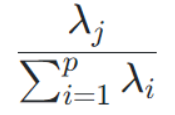

In [12]:
# Proporción acumulada de varianza explicada
var_acum = (Lambda / Lambda.sum()).cumsum()
print("Varianza explicada acumulada:", var_acum)

# Encontrar el número de componentes que explican al menos el 80%
n_components = np.argmax(var_acum >= 0.80) + 1
print(f"Componentes seleccionados: {n_components} (explican al menos el 80% de la varianza)")


Varianza explicada acumulada: [0.31089404 0.40650409 0.48373639 0.53459408 0.56741052 0.59873605
 0.62580244 0.64941769 0.67129147 0.68861163 0.70519766 0.7197714
 0.73232447 0.74436508 0.75451818 0.76330093 0.77110844 0.77861923
 0.78547037 0.79178183 0.7975528  0.80293392 0.80780688 0.81254625
 0.81709984 0.82135583 0.82529088 0.82898448 0.83255956 0.83598668
 0.8393391  0.84263119 0.84578438 0.84881387 0.85178577 0.8545601
 0.85731753 0.85998727 0.86256989 0.86507022 0.8674847  0.86984305
 0.8721422  0.87439279 0.87652317 0.87857922 0.88059618 0.88251995
 0.88443276 0.88629682 0.88809481 0.88984432 0.89155887 0.89321865
 0.89486143 0.8964615  0.89799396 0.89950443 0.90097736 0.90241089
 0.90382502 0.90519313 0.90653196 0.90783935 0.90911949 0.91036474
 0.91158005 0.91277301 0.91394736 0.91510685 0.91624587 0.91733579
 0.9184131  0.91948177 0.92053798 0.92157291 0.9226058  0.92360708
 0.92459097 0.92556002 0.926502   0.92742703 0.9283251  0.92920548
 0.93007824 0.9309425  0.93179363 

- A partir de la componente numero 22 ya se explica el 80% de la variabilidad, asi que tomamos las primeras 22 componentes, que en conjunto explican alrededor del 80%.

- Al seleccionar 22 componentes, significa que pasamos de tener 784 columnas a unicamente 22.

In [13]:
# Proyección de los datos a las componentes principales seleccionadas
Q_reducido = Q[:, :n_components]  # Seleccionar los primeros n_components eigenvectores
X_train_pca = np.dot(X_train - x_bar, Q_reducido)  # Transformar los datos de entrenaimiento
X_test_pca = np.dot(X_test - x_bar, Q_reducido)  # Transformar los datos de prueba
print("Dimensiones de los datos transformados (PCA):", X_train_pca.shape)  # (n_imágenes, n_components)
print("Dimensiones de los datos de prueba transformados (PCA):", X_test_pca.shape)

Dimensiones de los datos transformados (PCA): (21963, 22)
Dimensiones de los datos de prueba transformados (PCA): (5491, 22)


### ***4.1 Scree plot para verificar el numero de componentes***

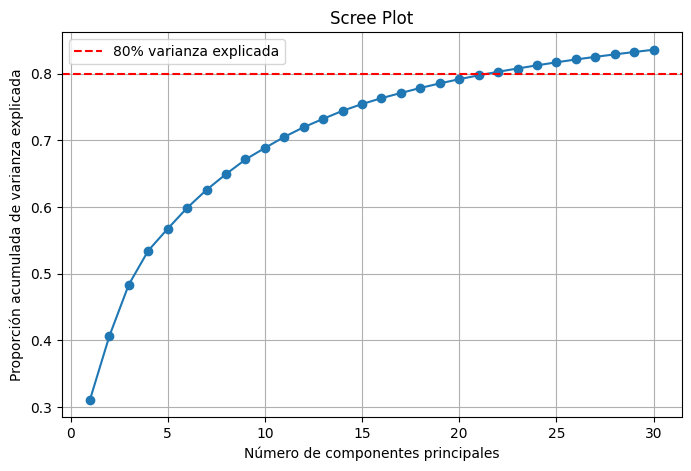

In [14]:
# Screen plot para las primeras 30 componentes
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 31), (Lambda[:30] / Lambda.sum()).cumsum(), marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% varianza explicada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Proporción acumulada de varianza explicada')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()



### ***Eigenvectores***
Toda la información que contienen nuestras imágenes está contenida en estos eigenvectores

Dimensiones de E (matriz de eigenvectores seleccionados): (784, 22)


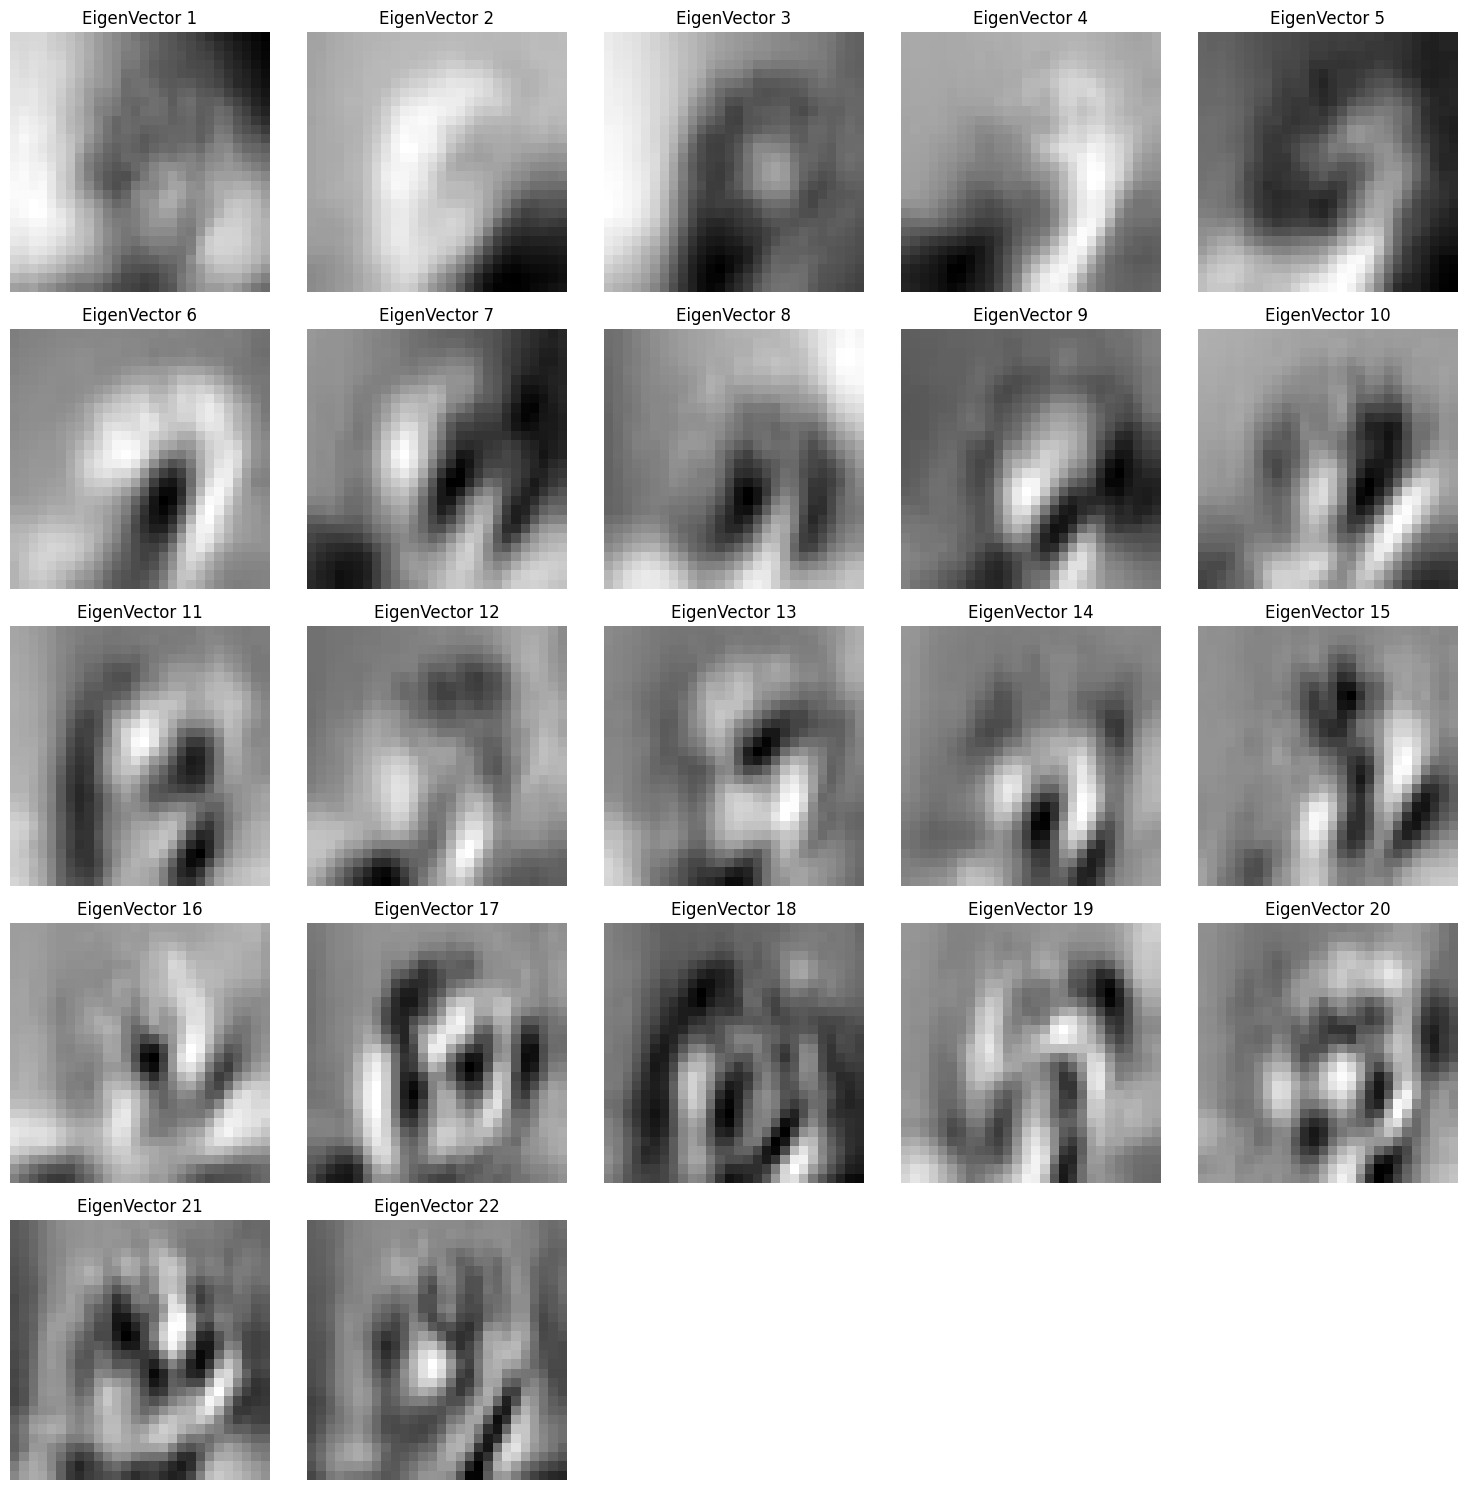

In [15]:
import matplotlib.pyplot as plt
import numpy as np

q = 22  # Número de componentes seleccionadas
E = Q[:, :q]  # Matriz de eigenvectores seleccionados
print("Dimensiones de E (matriz de eigenvectores seleccionados):", E.shape)  # (784, 22)

# Calcular filas y columnas para la cuadrícula
n_cols = 5  # Número de columnas
n_rows = (q + n_cols - 1) // n_cols  # Número de filas, para asegurar que todas las imágenes se muestren

# Graficar los primeros eigenvectores como imágenes
plt.figure(figsize=(15, 15))  # Ajustar el tamaño de la figura

for i in range(q):
    eigenimage = E[:, i].reshape(28, 28)  # Redimensionar para mostrar como imagen
    plt.subplot(n_rows, n_cols, i + 1)  # Distribuir en la cuadrícula
    plt.title(f"EigenVector {i + 1}")
    plt.imshow(eigenimage, cmap="gray")
    plt.axis("off")

plt.tight_layout()  # Asegurar que los subgráficos no se empalmen
plt.show()


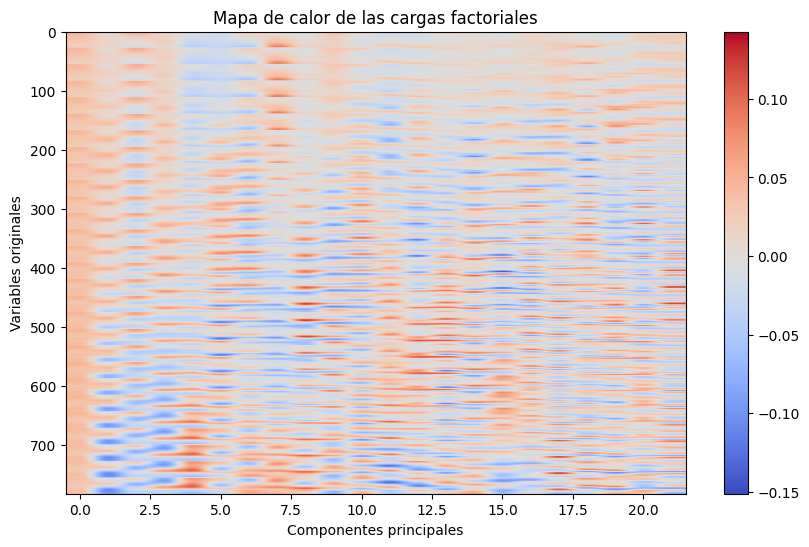

In [16]:
# Mapa de calor de cargas factoriales
plt.figure(figsize=(10, 6))
plt.imshow(E, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Mapa de calor de las cargas factoriales')
plt.xlabel('Componentes principales')
plt.ylabel('Variables originales')
plt.show()



# ***Entrenar Clasificadores de imágenes***

## Entrenar un clasificador KNN con PCA

Exactitud del clasificador KNN: 0.897650701147332


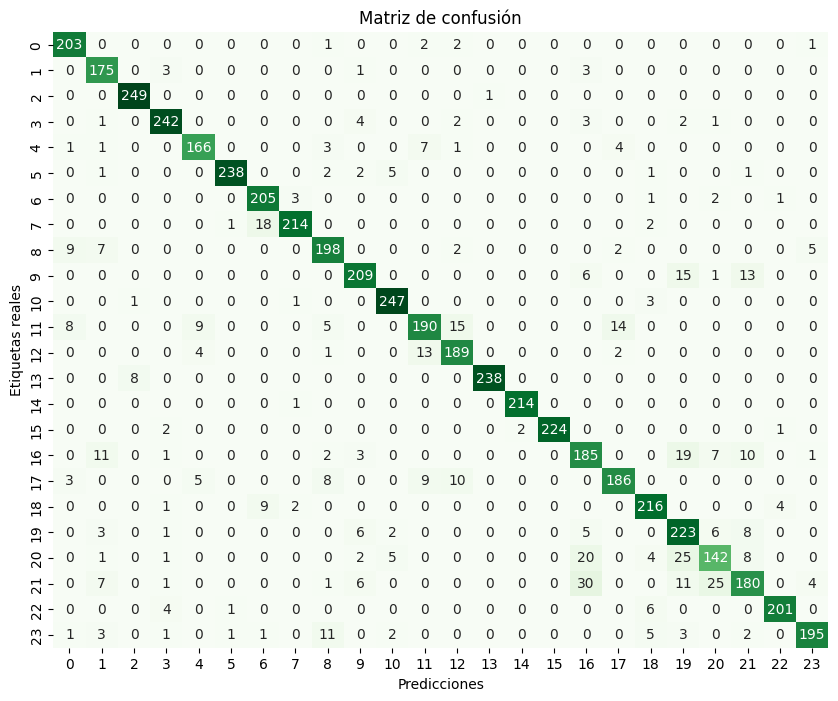

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=22)  # Usamos 5 vecinos como ejemplo
knn.fit(X_train_pca, y_train)  # Etiquetas solo para el conjunto de entrenamiento

# Realizar predicciones en el conjunto de prueba
predictions = knn.predict(X_test_pca)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador KNN:", accuracy)

# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas reales")
plt.title("Matriz de confusión")
plt.show()

In [18]:
# Graficar algunas predicciones con 2 componentes principales
plt.figure(figsize=(10, 10))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## Entrenar un clasificador KNN sin PCA

In [19]:
knn = KNeighborsClassifier(n_neighbors=22)  # Usamos 22 vecinos como ejemplo
knn.fit(X_train, y_train)  # Etiquetas solo para el conjunto de entrenamiento

# Realizar predicciones en el conjunto de prueba
predictions = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print("Exactitud del clasificador KNN:", accuracy)

Exactitud del clasificador KNN: 0.9657621562556912
